In [1]:
import NeuroAnalysisTools
import NeuroAnalysisTools.core.FileTools as ft
import NeuroAnalysisTools.RetinotopicMapping as rm
import pickle
import numpy as np
import pandas as pd
import os
from tifffile import imread, imwrite
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import cv2
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter, median_filter
import timeit
from glob import glob
from NatMovie_utils import *


In [2]:
path_wfield =r'/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/natural-movie/process/20240708-175712-wfield'

experiment = os.path.basename(path_wfield)[:15]
rawPath = pjoin(path_wfield, '../../raw')
path_out = pjoin(path_wfield, '..', experiment + '-natural-movie')
os.makedirs(path_out, exist_ok=True)
trialfile = pd.read_csv(pjoin(path_wfield, 'trials.csv'), header=None).values.astype(int)
movie_folder = pjoin(rawPath, 'natural_movies')
movie_list = pd.read_csv(pjoin(movie_folder, 'movie_list.txt'), header=None).values
n_movie = movie_list.size
movie_name_list = []
for imovie in range(n_movie):
    movie_name_list.append(str(movie_list[imovie])[2:-6])

n_frame = 150  # 帧


In [12]:
path_retinotopy = r'/home/lzx/data/WF_VC_liuzhaoxi/P73/20240718/retinotopy/process/20240718-161348-retinotopy'

with open(pjoin(path_retinotopy, 'retinotopy_out.pkl'), 'rb') as f:
    retino = pickle.load(f)
f.close()
n_patch = len(retino['finalPatchesMarked'])


In [13]:
U = np.load(pjoin(path_wfield, 'U.npy')).astype('float32')
SVTcorr = np.load(pjoin(path_wfield, 'SVTcorr.npy')).astype('float32')
frames_average = np.load(pjoin(path_wfield, 'frames_average.npy')).astype('float32')[0]


In [ ]:
pre_lenth = 0
after_lenth = 0
# SVTcorr_sort维度：[nSVD, n_frame, n_movie, n_rep]
SVTcorr_sort = sorting_NatMov(SVTcorr, trialfile[:, 1], n_movie, n_frame, pre_lenth, after_lenth).astype('float32')
print('SVTcorr_sort.shape: (nSVD, n_frame, n_movie, n_rep) ', SVTcorr_sort.shape)
n_rep = SVTcorr_sort.shape[-1]
SVTcorr_mean = np.mean(SVTcorr_sort, axis=3)


In [15]:

path_out_tif = pjoin(path_out, experiment + '-tif-rep-reshape')
os.makedirs(path_out_tif, exist_ok=True)
snr = np.empty((U.shape[0], U.shape[1], n_movie))

for imovie in range(n_movie):
    print('start processing {}-{}'.format(imovie + 1, movie_name_list[imovie]))
    tif_imovie = np.tensordot(U, SVTcorr_sort[:, :, imovie, :], axes=(2, 0)).astype('float32')
    snr[:, :, imovie] = cal_snr(tif_imovie, axis1=3, axis2=2)
    tif_imovie_mean = np.mean(tif_imovie, axis=3)
    tif_imovie_with_mean = np.concatenate((tif_imovie_mean[..., np.newaxis], tif_imovie), axis=3)
    tif_rep_reshape = np.concatenate(np.split(tif_imovie_with_mean, tif_imovie_with_mean.shape[3], axis=3),
                             axis=1).squeeze().transpose(2, 0, 1)
    # tif_imovie_mean = tif_imovie_mean.transpose(2, 0, 1)
    imwrite(pjoin(path_out_tif, movie_name_list[imovie] + '-rep-reshape.tif'), tif_rep_reshape, imagej=True)
print('export all rep_reshape-tifs')
np.save(pjoin(path_out, 'snr.npy'), snr)


start processing 1-forest
start processing 2-Heron
start processing 3-crow_peck_mouse1
start processing 4-owl_peck
start processing 5-cat
start processing 6-cat_catch_mouse1
start processing 7-cat_eat_mouse
start processing 8-cat_pat
start processing 9-run_to_cat
start processing 10-bugs
start processing 11-mouse_catch_bug
start processing 12-mouse_fight
start processing 13-mouse_birth
start processing 14-lawn_and_dog
export all rep_reshape-tifs


In [ ]:
path_out_rep_tif = pjoin(path_out, experiment + '-tif-rep')
os.makedirs(path_out_rep_tif, exist_ok=True)

tif_sort = np.tensordot(U, SVTcorr_sort, axes=(2, 0)).astype('float32')
# tif_sort维度：[width, height, n_frame, n_movie, n_rep]
tif_mean = np.mean(tif_sort, axis=-1)
tif_with_mean = np.concatenate((tif_mean[..., np.newaxis], tif_sort), axis=-1)
tif_rep_reshape = np.concatenate(np.split(tif_with_mean, tif_with_mean.shape[-1], axis=-1),
                                 axis=1).squeeze().transpose(2, 0, 1, 3)
for imovie in range(n_movie):
    print('start processing {}-{}'.format(imovie + 1, movie_name_list[imovie]))
    imwrite(pjoin(path_out_rep_tif, movie_name_list[imovie] + '-rep-reshape.tif'), tif_rep_reshape[:, :, :, imovie].astype('float32'),
            imagej=True)
print('export all rep-reshape-tifs')

tif_rep = np.concatenate(np.split(tif_sort, tif_sort.shape[-1], axis=-1),
                         axis=2).squeeze().transpose(2, 0, 1, 3)
for imovie in range(n_movie):
    print('start processing {}-{}'.format(imovie + 1, movie_name_list[imovie]))
    imwrite(pjoin(path_out_rep_tif, movie_name_list[imovie] + '-rep.tif'),
            tif_rep[:, :, :, imovie].astype('float32'), imagej=True)
print('export all rep-tifs')


In [4]:
from wfield import *

lmarks = load_allen_landmarks(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'))
ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
# this loads the untransformed atlas
atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'),
                                                            do_transform=True)
# this converts the reference to image space (unwarped)
ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
                                         resolution=lmarks['resolution'],
                                         bregma_offset=lmarks['bregma_offset'])



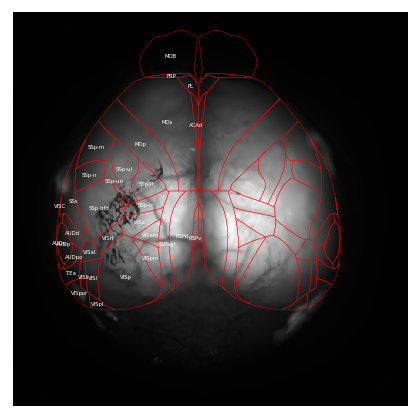

In [17]:
merge_frame_size = (512, 512)  # (width, height)
fig = plt.figure(figsize=(merge_frame_size[0] / 128, merge_frame_size[1] / 128), dpi=128)
plt.imshow(frames_average, cmap='gray')
for i, r in ccf_regions_im.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=1, ha='center')

plt.axis('off')
fig.set_facecolor('white')
plt.savefig(pjoin(path_out, 'ccf.png'), bbox_inches='tight', pad_inches=0)
plt.show()


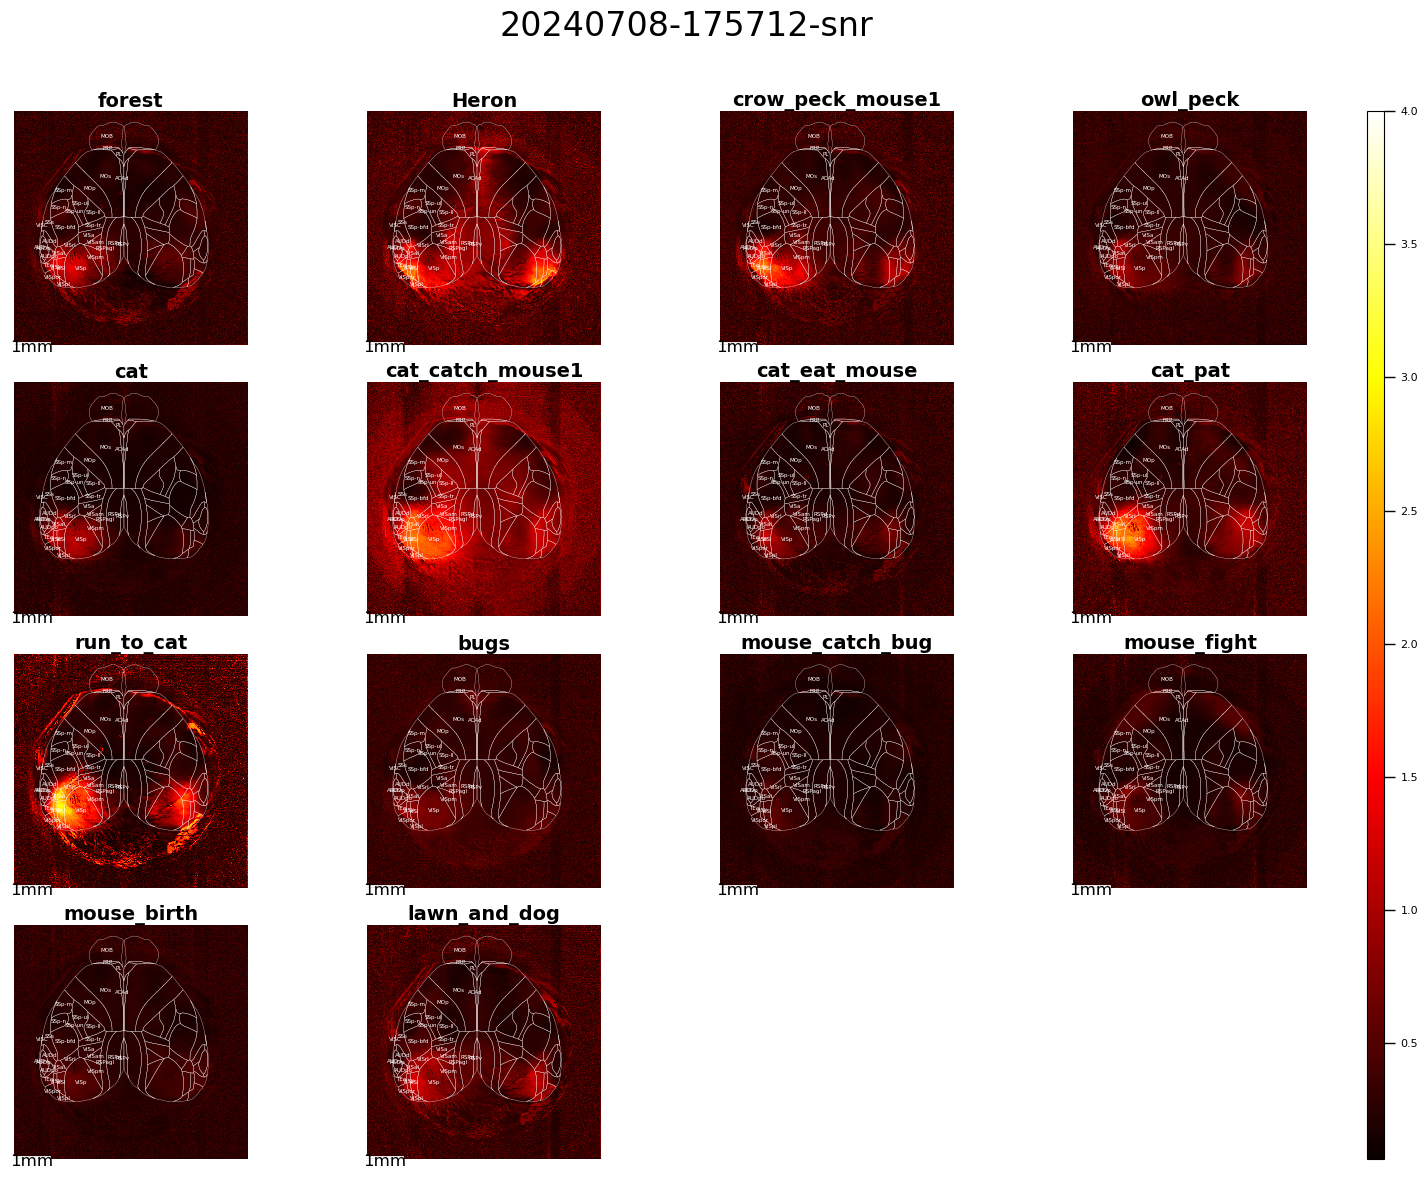

In [18]:
snr = np.load(pjoin(path_out, 'snr.npy'))
subplot_movie_heatmap(snr, 4, 4, movie_name_list, path_outfile=pjoin(path_out, 'SNR_per_movie.png'),
                      title=experiment + '-snr', vmax=4, pixel_um=13, patches=None,
                      ccf_regions=ccf_regions_im)

# std = np.std(tif_sort, axis=(2, 4))
# np.save(pjoin(path_out, 'std.npy'), std)
# subplot_movie_heatmap(std, 4, 4, movie_list, path_outfile=pjoin(path_out, 'std_per_movie.png'), title=experiment+'-std', vmin=0.01, vmax=0.1,
#                       pixel_um=13, patches=None, ccf_regions=ccf_regions_im)


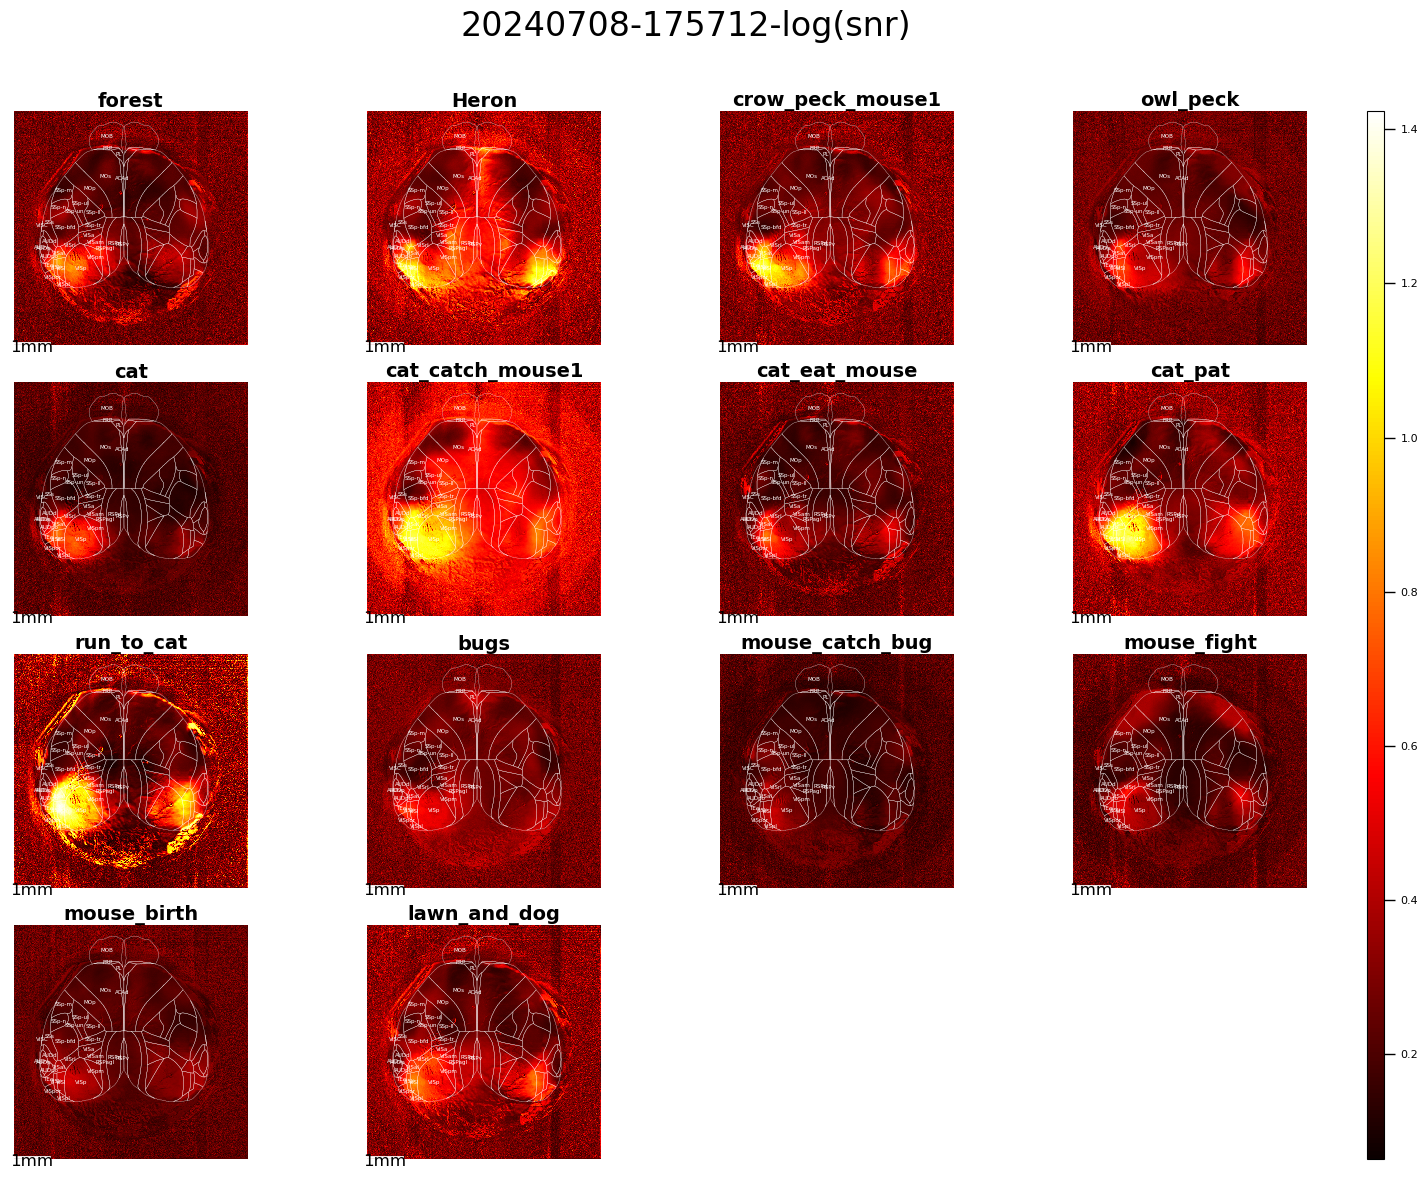

In [19]:
logSNR=np.log(snr+1)
subplot_movie_heatmap(logSNR, 4, 4, movie_name_list, path_outfile=pjoin(path_out, 'logSNR_per_movie.png'),
                      cmap='hot', title=experiment + '-log(snr)', pixel_um=13, patches=None,
                      ccf_regions=ccf_regions_im)

In [ ]:
from pupil_utils import *

path_pupil = pjoin(path_out, experiment + '-pupil')
pupil_pkl_data = glob(pjoin(path_pupil, '*pupil_detection*.pkl'))[0]
with open(pupil_pkl_data, 'rb') as f:
    pupil_pkl = pickle.load(f)
f.close()

pupil_area_sort = sorting_NatMov_pupil(pupil_pkl['Pupil_area'], trialfile[:, 1], n_movie, n_frame)
# pupil_area_sort_nmovie = np.concatenate(np.split(pupil_area_sort, pupil_area_sort.shape[2], axis=2),
#                                         axis=0).squeeze().transpose(1, 0)
pupil_area_sort_nmovie = pupil_area_sort.transpose(1, 0, 2).reshape(n_movie, n_frame * n_rep)
# tif_nmovie = np.concatenate(np.split(tif_sort, tif_sort.shape[-1], axis=-1),
#                                         axis=-3).squeeze().transpose(0, 1, 3, 2)
tif_nmovie = tif_sort.transpose(0, 1, 3, 2, 4).reshape(*tif_sort.shape[0:2], n_movie, n_frame * n_rep)
pupil_cor = np.empty((tif_nmovie.shape[:3]))
def cal_corrcoef(A, B, rowvar=False):
    # 计算arr和B的相关系数
    return np.corrcoef(A, B, rowvar=rowvar)[0, 1]
for imovie in range(n_movie):
    pupil_cor[:, :, imovie] = np.apply_along_axis(cal_corrcoef, -1, tif_nmovie[:, :, imovie, :],
                                                  B=pupil_area_sort_nmovie[imovie, :])
np.save(pjoin(path_pupil, 'pupil_corrcoef.npy'), pupil_cor)
subplot_movie_heatmap(pupil_cor[:, :, :12], 4, 4, movie_list,
                      path_outfile=pjoin(path_out, 'pupil_corrcoef_per_movie.png'), title=experiment + '-corrcoef',
                      cmap='coolwarm', pixel_um=13, patches=None, ccf_regions=ccf_regions_im, ccf_color='k')

# 画瞳孔大小变化
fig, axes = plt.subplots(5, 14, figsize=(50, 6))
for i_rep in range(5):
    for i_movie in range(14):
        axes[i_rep, i_movie].plot(pupil_area_sort[:, i_movie, i_rep])
        axes[i_rep, i_movie].set_xlim(0, n_frame)
        axes[i_rep, i_movie].set_title(movie_name_list[i_movie], fontsize=5)
        axes[i_rep, i_movie].tick_params(labelsize=5)
plt.tight_layout()
fig.set_facecolor('white')
plt.savefig(pjoin(path_pupil, 'pupil_area_change.png'))
plt.show()


In [ ]:
path_patch_stim = pjoin(path_out, experiment + '-patch-stim')
os.makedirs(path_patch_stim, exist_ok=True)
for imovie in range(n_movie):
    movie_name = movie_name_list[imovie]
    movie_file = pjoin(movie_folder, movie_name + '.mp4')
    tif_file = pjoin(path_out_tif, movie_name + '.tif')
    merge_file = pjoin(path_patch_stim, movie_name + '-patch-stim.mp4')
    merge_patch_stim(merge_file, tif_file, movie_file, clip=0.05, patches=retino['finalPatchesMarked'], ncol=1,
                     text='{}-{} '.format(imovie + 1, movie_name))
    print('finish merging {}-{}'.format(imovie + 1, movie_name))

print('finish all merging')


In [ ]:
path_ccf = pjoin(path_out, experiment + '-ccf')
os.makedirs(path_ccf, exist_ok=True)

for imovie in range(n_movie):
    # reconstruct the mean movie
    SVT_mean_imovie = SVTcorr_mean[:, :, imovie]
    stack = SVDStack(U, SVT_mean_imovie)
    stack.set_warped(False, M=lmarks['transform'])

    mp4_outfile = pjoin(path_ccf, movie_name_list[imovie] + '-ccf.mp4')
    out = cv2.VideoWriter(mp4_outfile, cv2.VideoWriter_fourcc(*'mp4v'), 10, merge_frame_size)
    if not out.isOpened():
        print("视频文件无法打开：", mp4_outfile)
        continue

    for iframe in range(n_frame):
        # plot iframe with allen map
        fig = plt.figure(figsize=(merge_frame_size[0] / 128, merge_frame_size[1] / 128), dpi=128)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0, 0)
        plt.imshow(reconstruct(stack.originalU, stack.SVT[:, iframe]), clim=[-0.05, 0.05], cmap='gray')
        for i, r in ccf_regions_im.iterrows():
            plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
            plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
            plt.text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=6, alpha=0.5,
                     ha='center')
        plt.axis('off')
        fig.set_facecolor('white')
        # export to mp4 video
        # plt.savefig(pjoin(mp4_outfile, 'tmp.png'), bbox_inches='tight', pad_inches=0)
        # frame_bgr = cv2.imread('tmp/frame{}.png'.format(iframe + 1))
        fig.canvas.draw()
        frame_argb = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
        frame_rgba = np.roll(frame_argb.reshape(fig.canvas.get_width_height()[::-1] + (4,)), 3, axis=2)
        frame_bgr = cv2.cvtColor(frame_rgba, cv2.COLOR_RGBA2BGR)
        plt.close(fig)

        if frame_bgr is None:
            print('帧数据为空：第 {} 帧'.format(iframe + 1))
            print('error when merging {}.mp4'.format(movie_name_list[imovie]))
            break

        if frame_bgr.shape[1] != merge_frame_size[0] or frame_bgr.shape[0] != merge_frame_size[1]:
            print('帧大小不匹配：第 {} 帧，大小 {}'.format(iframe + 1, frame_bgr.shape))
            # 调整帧大小
            frame_bgr = cv2.resize(frame_bgr, merge_frame_size, interpolation=cv2.INTER_LINEAR)

        # 写入帧到视频
        out.write(frame_bgr)
        print('finish merging {} {}th frame'.format(movie_name_list[imovie], iframe + 1))

    out.release()
    print('finish merging all frames of {}.mp4'.format(movie_name_list[imovie]))

# merge tif & ccf & stim
path_ccf = pjoin(path_out, experiment + '-ccf')
path_ccf_stim = pjoin(path_out, experiment + '-ccf-stim')
os.makedirs(path_ccf_stim, exist_ok=True)

for imovie in range(n_movie):
    movie_name = movie_name_list[imovie]
    movie_file = pjoin(movie_folder, movie_name + '.mp4')
    tif_file = pjoin(path_ccf, movie_name + '-ccf.mp4')
    merge_file = pjoin(path_ccf_stim, movie_name + '-ccf-stim.mp4')
    merge2video(merge_file, tif_file, movie_file, text='{}-{} '.format(imovie + 1, movie_name))
    print('finish merging {}-{}'.format(imovie + 1, movie_name))

print('finish all merging')


In [ ]:
path_enhance_ccf_stim = pjoin(path_out, experiment + '-enhance-ccf-stim')
os.makedirs(path_enhance_ccf_stim, exist_ok=True)
for imovie in range(n_movie):
    movie_name = movie_name_list[imovie]
    movie_file = pjoin(movie_folder, movie_name + '.mp4')
    tif_file = pjoin(path_out, experiment + '-tif-enhance', movie_name + '_enhance.tif')
    merge_file = pjoin(path_enhance_ccf_stim, movie_name + '-ccf-stim.mp4')
    merge_ccf_stim(merge_file, tif_file, ccf_regions_im, stim_file=movie_file, tif_fps=10, vmin=200, vmax=25000,
                   trial_rep=1, text='{}-{} '.format(imovie + 1, movie_name))
    print('finish merging {}-{}'.format(imovie + 1, movie_name))
print('finish all merging')

path_rep_reshape_ccf_stim = pjoin(path_out, experiment + '-rep-reshape-ccf-stim')
os.makedirs(path_rep_reshape_ccf_stim, exist_ok=True)
for imovie in range(n_movie):
    movie_name = movie_name_list[imovie]
    movie_file = pjoin(movie_folder, movie_name + '.mp4')
    tif_file = pjoin(path_out, experiment + '-tif-rep-reshape', movie_name + '-rep-reshape.tif')
    merge_file = pjoin(path_rep_reshape_ccf_stim, movie_name + '-rep-reshape-ccf-stim.mp4')
    merge_ccf_stim(merge_file, tif_file, ccf_regions_im, stim_file=movie_file, ncol=6, nrow=1, vmin=-0.1, vmax=0.1,
                   trial_rep=1, text='{}-{} '.format(imovie + 1, movie_name))
    print('finish merging {}-{}'.format(imovie + 1, movie_name))
print('finish all merging')

path_rep_reshape_enhance_ccf_stim = pjoin(path_out, experiment + '-rep-reshape-enhance-ccf-stim')
os.makedirs(path_rep_reshape_enhance_ccf_stim, exist_ok=True)
for imovie in range(n_movie):
    movie_name = movie_name_list[imovie]
    movie_file = pjoin(movie_folder, movie_name + '.mp4')
    tif_file = pjoin(path_out, experiment + '-tif-rep-reshape-enhance', movie_name + '-rep-reshape-enhance.tif')
    merge_file = pjoin(path_rep_reshape_enhance_ccf_stim, movie_name + '-rep-reshape-enhance-ccf-stim.mp4')
    merge_ccf_stim(merge_file, tif_file, ccf_regions_im, stim_file=movie_file, ncol=5, nrow=1, vmin=200, vmax=25000,
                   trial_rep=1, text='{}-{} '.format(imovie + 1, movie_name))
    print('finish merging {}-{}'.format(imovie + 1, movie_name))
print('finish all merging')

path_rep_enhance_ccf_stim = pjoin(path_out, experiment + '-rep-enhance-ccf-stim')
os.makedirs(path_rep_enhance_ccf_stim, exist_ok=True)
for imovie in range(n_movie):
    movie_name = movie_name_list[imovie]
    movie_file = pjoin(movie_folder, movie_name + '.mp4')
    tif_file = pjoin(path_out, experiment + '-tif-rep-enhance', movie_name + '-rep-enhance.tif')
    merge_file = pjoin(path_rep_enhance_ccf_stim, movie_name + '-rep-enhance-ccf-stim.mp4')
    merge_ccf_stim(merge_file, tif_file, ccf_regions_im, stim_file=movie_file, tif_fps=10, vmin=200, vmax=25000,
                   trial_rep=10, text='{}-{} '.format(imovie + 1, movie_name))
    print('finish merging {}-{}'.format(imovie + 1, movie_name))
print('finish all merging')

path_rep_ccf_stim = pjoin(path_out, experiment + '-rep-ccf-stim')
os.makedirs(path_rep_ccf_stim, exist_ok=True)
for imovie in range(n_movie):
    movie_name = movie_name_list[imovie]
    movie_file = pjoin(movie_folder, movie_name + '.mp4')
    tif_file = pjoin(path_out, experiment + '-tif-rep', movie_name + '-rep.tif')
    merge_file = pjoin(path_rep_ccf_stim, movie_name + '-rep-ccf-stim.mp4')
    merge_ccf_stim(merge_file, tif_file, ccf_regions_im, stim_file=movie_file, tif_fps=10, vmin=-0.1, vmax=0.1,
                   trial_rep=10, text='{}-{} '.format(imovie + 1, movie_name))
    print('finish merging {}-{}'.format(imovie + 1, movie_name))
print('finish all merging')


In [5]:
path_rep_reshape_ccf_stim = pjoin(path_out, experiment + '-rep-reshape-ccf-stim')
os.makedirs(path_rep_reshape_ccf_stim, exist_ok=True)
for imovie in range(n_movie):
    movie_name = movie_name_list[imovie]
    movie_file = pjoin(movie_folder, movie_name + '.mp4')
    tif_file = pjoin(path_out, experiment + '-tif-rep-reshape', movie_name + '-rep-reshape.tif')
    merge_file = pjoin(path_rep_reshape_ccf_stim, movie_name + '-rep-reshape-ccf-stim.mp4')
    merge_ccf_stim(merge_file, tif_file, ccf_regions_im, stim_file=movie_file, ncol=6, nrow=1, vmin=-0.1, vmax=0.1,
                   trial_rep=1, text='{}-{} '.format(imovie + 1, movie_name), reverse=False)
    print('finish merging {}-{}'.format(imovie + 1, movie_name))
print('finish all merging')

finish merging 1-forest 1th frame
finish merging 1-forest 2th frame
finish merging 1-forest 3th frame
finish merging 1-forest 4th frame
finish merging 1-forest 5th frame
finish merging 1-forest 6th frame
finish merging 1-forest 7th frame
finish merging 1-forest 8th frame
finish merging 1-forest 9th frame
finish merging 1-forest 10th frame
finish merging 1-forest 11th frame
finish merging 1-forest 12th frame
finish merging 1-forest 13th frame
finish merging 1-forest 14th frame
finish merging 1-forest 15th frame
finish merging 1-forest 16th frame
finish merging 1-forest 17th frame
finish merging 1-forest 18th frame
finish merging 1-forest 19th frame
finish merging 1-forest 20th frame
finish merging 1-forest 21th frame
finish merging 1-forest 22th frame
finish merging 1-forest 23th frame
finish merging 1-forest 24th frame
finish merging 1-forest 25th frame
finish merging 1-forest 26th frame
finish merging 1-forest 27th frame
finish merging 1-forest 28th frame
finish merging 1-forest 29th 

In [ ]:
from pupil_utils import *

path_pupil = pjoin(path_out, experiment + '-pupil')
pupil_video_data = glob(pjoin(path_pupil, '*pupil_detection*.mp4'))[0]
pupil_video = read_video(pupil_video_data)
pupil_video_sort = sorting_NatMov_pupil(np.asarray(pupil_video), trialfile[:, 1], n_movie, n_frame)
pupil_video_sort_nmovie = np.concatenate(np.split(pupil_video_sort, pupil_video_sort.shape[2], axis=2),
                                         axis=0).squeeze()

face_video_data = glob(pjoin(path_pupil, experiment + '-event.avi'))[0]
face_video = read_video(face_video_data)
face_video_sort = sorting_NatMov_pupil(np.asarray(face_video), trialfile[:, 1], n_movie, n_frame)
face_video_height, face_video_width = face_video[0].shape[:2]
face_video_sort_nmovie = np.concatenate(np.split(face_video_sort, face_video_sort.shape[2], axis=2),
                                        axis=0).squeeze()

tif_width = 512
tif_height = 512

# ~~~~~~~~~~ start merging face video & pupil video ~~~~~~~~~~
path_pupil_rep_enhance_merge = pjoin(path_out, experiment + '-rep-enhance-pupil')
os.makedirs(path_pupil_rep_enhance_merge, exist_ok=True)

for imovie in range(n_movie):
    path_rep_enhance_ccf_stim = pjoin(path_out, experiment + '-rep-enhance-ccf-stim')
    WF_videofile = pjoin(path_rep_enhance_ccf_stim, movie_name_list[imovie] + '-rep-enhance-ccf-stim.mp4')
    pupil_mergefile = pjoin(path_pupil_rep_enhance_merge, movie_name_list[imovie] + '-rep-enhance-pupil.mp4')
    text = movie_name_list[imovie] + '-rep-enhance-pupil '
    merge_pupil_face_video(pupil_video_sort_nmovie, face_video_sort_nmovie, WF_videofile, pupil_mergefile, tif_width,
                           tif_height, text=text)

# ~~~~~~~~~~ start merging face video & pupil video ~~~~~~~~~~
path_pupil_rep_merge = pjoin(path_out, experiment + '-rep-pupil')
os.makedirs(path_pupil_rep_merge, exist_ok=True)

for imovie in range(n_movie):
    path_rep_ccf_stim = pjoin(path_out, experiment + '-rep-ccf-stim')
    WF_videofile = cv2.VideoCapture(pjoin(path_rep_ccf_stim, movie_name_list[imovie] + '-rep-ccf-stim.mp4'))
    pupil_mergefile = pjoin(path_pupil_rep_merge, movie_name_list[imovie] + '-rep-pupil.mp4')
    text = movie_name_list[imovie] + '-rep-pupil '
    merge_pupil_face_video(pupil_video_sort_nmovie, face_video_sort_nmovie, WF_videofile, pupil_mergefile, tif_width,
                           tif_height, text=text)

# ~~~~~~~~~~ start merging face video & pupil video ~~~~~~~~~~
path_pupil_merge = pjoin(path_out, experiment + '-avg-pupil')
os.makedirs(path_pupil_merge, exist_ok=True)

for imovie in range(n_movie):
    path_ccf_stim = pjoin(path_out, experiment + '-avg-ccf-stim')
    WF_videofile = cv2.VideoCapture(pjoin(path_ccf_stim, movie_name_list[imovie] + '-ccf-stim.mp4'))
    pupil_mergefile = pjoin(path_pupil_merge, movie_name_list[imovie] + '-avg-pupil.mp4')
    text = movie_name_list[imovie] + '-avg-pupil '
    merge_pupil_face_video(pupil_video_sort_nmovie, face_video_sort_nmovie, WF_videofile, pupil_mergefile, tif_width,
                           tif_height, text=text)



In [ ]:
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])
# this loads the atlas in transformed coords
atlas, areanames, brain_mask = atlas_from_landmarks_file(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'))
# this does the transform (warps the original images (the spatial components in the stack))
stack = SVDStack(U,SVTcorr)
stack.set_warped(True, M = lmarks['transform'])


In [ ]:
fig = plt.figure()
# plt.imshow(stack.U_warped[:,:,0], clim=[-0.01,0.01], cmap='coolwarm')
# plt.imshow(stack.originalU[:,:,0], clim=[-0.01,0.01], cmap='coolwarm')
plt.imshow(reconstruct(stack.U_warped,stack.SVT[:,800]), clim=[-0.03,0.03], cmap='gray')
# plot the raw reference because the images were converted
plt.colorbar()
for i,r in ccf_regions.iterrows():
    plt.plot(r['left_x'],r['left_y'],'k',lw=0.3)
    plt.plot(r['right_x'],r['right_y'],'k',lw=0.3)
plt.axis('off')
plt.show()


In [ ]:
pre_lenth = 20
after_lenth = 20
# SVTcorr_sort维度：[nSVD, n_frame, n_movie, n_rep]
SVTcorr_sort = sorting_NatMov(SVTcorr, trialfile[:, 1], n_movie, n_frame, pre_lenth, after_lenth).astype('float32')
print('SVTcorr_sort.shape: (nSVD, n_frame, n_movie, n_rep) ', SVTcorr_sort.shape)
n_rep = SVTcorr_sort.shape[-1]


In [ ]:

n_pc = 3
patch_list = ['V1', 'LM', 'RL', 'AL', 'AM', 'PM', 'P']

patch_pca = np.zeros((n_patch, n_movie, n_pc, n_frame + pre_lenth + after_lenth, n_rep))
patch_pca_var = np.zeros((n_patch, 10))

for i_patch, patch in enumerate(patch_list):
    # 只保留对应脑区像素
    patch_mask = retino['finalPatchesMarked'][patch].array
    patch_tif = np.tensordot(U * patch_mask[:, :, None], SVTcorr_sort, axes=(2, 0)).astype('float16')
    patch_tif = patch_tif[patch_mask != 0]

    # PCA
    patch_tif_2d = patch_tif.reshape(patch_tif.shape[0], -1).T
    pca = PCA(n_components=10)
    pca.fit(patch_tif_2d)
    patch_pc = pca.components_[:n_pc, :]
    patch_pc = np.where(np.mean(patch_pc, axis=1) < 0, -1, 1)[:, None] * patch_pc  # 确保主成分方向为正
    patch_scores = patch_pc @ patch_tif_2d.T
    patch_scores = patch_scores.reshape(n_pc, *patch_tif.shape[1:]).transpose(2, 0, 1, 3)
    # patch_scores = pca.transform(patch_tif_2d)[:,:n_pc].T.reshape(n_pc, *patch_tif.shape[1:]).transpose(2, 0, 1, 3)
    # patch_scores维度[n_movie, n_pc, n_frame, n_rep]
    print('finish PCA of {}'.format(patch))
    patch_pca[i_patch, :, :, :, :] = patch_scores
    patch_pca_var[i_patch, :] = pca.explained_variance_ratio_

np.save(pjoin(path_out, 'patch_pca_scores.npy'), patch_pca)  # 维度(n_patch, n_movie, n_pc, n_frame, n_rep)
patch_pca_var_df = pd.DataFrame(patch_pca_var, index=patch_list,
                                columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
patch_pca_var_df.to_csv(pjoin(path_out, 'patch_pca_var.csv'), index=True)


In [ ]:
# patch_pca = np.load(pjoin(path_out, 'patch_pca_scores.npy'))
#
# # 如果patch需要重新排序
# patch_list_raw = []
# with open(pjoin(path_out, 'patch_list.txt'), 'r') as f:
#     for line in f:
#         patch_list_raw.append(line.strip())
#
# patch_list_reorder = ['V1', 'LM', 'RL', 'AL', 'AM', 'PM', 'A']
# patch_list_index = [patch_list_raw.index(patch) for patch in patch_list_reorder]
# patch_pca_reorder = patch_pca[patch_list_index, :, :, :, :]


In [ ]:
plot_pca(patch_pca, n_patch, n_movie, patch_list, movie_name_list, title=experiment, outpath=path_out,
         pre_lenth=pre_lenth, n_frame=n_frame)

# pca_all = np.concatenate((pca1, pca2, pca3, pca4), axis=-1)
# np.save(pjoin(r'D:\Zhaoxi\mouse_vision\data', 'patch_pca_scores_all.npy'), pca_all)
# plot_pca(pca_all, n_patch, n_movie, patch_list, movie_name_list, title='C92', outpath=r'D:\Zhaoxi\mouse_vision',
#          pre_lenth=pre_lenth, n_frame=n_frame)



In [ ]:
mask = imread(pjoin(path_wfield, 'mask.tif'))
mask = np.where(mask > 0, 1, 0)
# mask = np.rot90(mask, k=3)  # 逆时针旋转90度
u = U * mask[:, :, None]
u = U

In [ ]:
Sigma = np.sqrt(np.sum(SVTcorr ** 2, axis=1))
Sigma = Sigma[:100]
s = np.diag(Sigma)
us = u[:, :, :100] @ s
u_pca = us.reshape(U.shape[0] * U.shape[1], -1)



In [ ]:
'''
a = np.random.randint(0,100,size=(5, 5, 10, 10))
a = a - a.mean()
n_pc = a.shape[0] * a.shape[1]
a_2d = a.reshape(a.shape[0]*a.shape[1], -1).T

# 创建PCA对象
pca = PCA(n_components=n_pc)
# 对a进行主成分分析
pca.fit(a_2d)
# 获取主成分
a_pc = pca.components_.T.reshape(*a.shape[:2], n_pc)
# 获取样本的主成分得分
a_scores = pca.transform(a_2d).T.reshape(n_pc, *a.shape[2:])

a_reconstruct=np.tensordot(a_pc, a_scores, axes=(2, 0))
b = np.random.randint(0,2,size=(a.shape[0], a.shape[1]))

c1 = np.tensordot(a_pc, a_scores, axes=(2, 0)) * b[:, :, None, None]
c1= c1[b != 0]

c2 = np.tensordot(a_pc * b[:, :, None], a_scores, axes=(2, 0))
c2= c2[b != 0]

c1==c2


a.std()-a_reconstruct.std()
Out[233]: 0.07505080233665495
(a-a_reconstruct).std()
Out[234]: 2.0779428930234505
np.sum(a-a_reconstruct)
Out[218]: 1.4210854715202004e-14
a.mean()-a_reconstruct.mean()
Out[237]: -3.2236534429507125e-15
'''


In [ ]:
'''
mean_patch_movie = pd.DataFrame(index=retino['finalPatchesMarked'].keys(), columns=movie_name_list)
mean_patch_movie_rep = pd.DataFrame(index=retino['finalPatchesMarked'].keys(), columns=movie_name_list)

for i in range(n_movie):
    print('start processing {}-{}'.format(i+1, str(movie_list[i])[2:-6]))
    tif_imovie = np.tensordot(U, SVTcorr_sort[:, :, i, :], axes=(2, 0)).astype('float32')
    tif_imovie_frame_mean = np.mean(tif_imovie, axis=2)
    tif_imovie_frame_rep_mean = np.mean(tif_imovie_frame_mean, axis=2)
    for j in retino['finalPatchesMarked'].keys():
        patch_npix = np.count_nonzero(retino['finalPatchesMarked'][j].array)
        npix_total = np.sum(retino['finalPatchesMarked'][j].array * tif_imovie_frame_rep_mean)
        mean_patch_movie.loc[j, movie_name_list[i]] = npix_total / patch_npix
        npix_total_rep = np.asarray(retino['finalPatchesMarked'][j].array.reshape(-1)) @ tif_imovie_frame_mean.reshape(-1, n_rep)
        mean_patch_movie_rep.loc[j, movie_name_list[i]] = npix_total_rep / patch_npix
print('finish mean_patch_movie')

mean_patch_movie.to_csv(pjoin(path_out,'mean_patch_movie.csv'), index=True)
mean_patch_movie_rep.to_csv(pjoin(path_out,'mean_patch_movie_rep.csv'), index=True)


In [ ]:
for col in mean_patch_movie.columns:
    mean_patch_movie[col] = pd.to_numeric(mean_patch_movie[col])
means = mean_patch_movie.to_numpy()

mean_list = np.array(mean_patch_movie_rep.to_numpy().tolist())
n_patch = mean_list.shape[0]
means_rep = mean_list.reshape(n_patch, n_movie, n_rep)

plot_heatmap(means, mean_patch_movie.columns, mean_patch_movie.index, vmin=-0.002, vmax=0.007,
             title='mean of repetition and frames', outfile=pjoin(path_out, 'mean_patch_movie.png'))



In [ ]:
import seaborn as sns

def str_to_matrix(s):
    # 去除首尾的方括号，并将字符串以空格分隔为列表
    values = s.strip('[]').split()
    # 将列表中的字符串转换为 float 类型，并重新组成矩阵
    matrix = np.array([float(val) for val in values], dtype=np.float32)
    return matrix

def read_df_csv(file_path, index_list):
    df = pd.read_csv(file_path, index_col=0)
    df = df.applymap(str_to_matrix)
    df = df.reindex(index_list)
    array = np.array(df.to_numpy().tolist())
    return array


In [ ]:
patch_list = ['V1', 'LM', 'RL', 'AL', 'AM', 'PM', 'A']
patch_movie1 = read_df_csv(r'Y:\WF_VC_liuzhaoxi\24.3.27_C92\natural-movie\process\20240327-183009-natural-movie\mean_patch_movie_rep.csv', patch_list)
patch_movie2 = read_df_csv(r'Y:\WF_VC_liuzhaoxi\24.04.03_C92\natural-movie\process\20240403-161209-natural-movie\mean_patch_movie_rep.csv', patch_list)
patch_movie3 = read_df_csv(r'Y:\WF_VC_liuzhaoxi\24.04.03_C92\natural-movie\process\20240403-172109-natural-movie\mean_patch_movie_rep.csv', patch_list)
patch_movie4 = read_df_csv(r'Y:\WF_VC_liuzhaoxi\24.04.03_C92\natural-movie\process\20240403-192107-natural-movie\mean_patch_movie_rep.csv', patch_list)
patch_movie_all = np.concatenate((patch_movie1,patch_movie2,patch_movie3,patch_movie4), axis=2)
patch_movie_all_mean = np.mean(patch_movie_all, axis=2)
patch_movie_all_mean_df = pd.DataFrame(patch_movie_all_mean, index=patch_list, columns=movie_name_list)
patch_movie_all_mean_df.to_csv('patch_movie_20rep-mean.csv')


In [ ]:
cor_rep = np.array([np.corrcoef(rep) for rep in patch_movie_all.transpose(2, 0, 1)])
cor_mean = np.mean(cor_rep, )
cor_df = pd.DataFrame(cor_mean, index=patch_list, columns=patch_list)
cor_df.to_csv('cor_mean.csv')


In [ ]:
n_max=5
max_indices_mean = np.argsort(-patch_movie_all_mean, axis=1)[:, :n_max]
max_indices = np.argsort(-patch_movie_all, axis=1)[:, :n_max, :]
# 初始化一个空列表来存储每个脑区的交集
intersection_list = []
# 对于每个脑区
for i in range(n_patch):
    # 创建一个集合，包含所有重复的 top3 坐标
    top3_set = set(max_indices[i, :, :].flatten())
    # 对于每个重复
    for j in range(max_indices.shape[2]):
        # 创建一个集合，包含当前重复的 top3 坐标
        rep_set = set(max_indices[i, :, j])
        # 取当前重复的 top3 坐标与之前重复的 top3 坐标集合的交集
        top3_set.intersection_update(rep_set)
    # 将当前脑区的交集添加到列表中
    intersection_list.append(top3_set)
# 打印结果
for i, intersection in enumerate(intersection_list):
    print(f"Brain region {i+1} intersection:", intersection)



In [ ]:
cluster = pd.read_csv('clustered_df.csv', index_col=0)
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor('white')
sns.boxplot(data=cluster, ax=ax, showfliers=True)
# sns.stripplot(data=patch_movie_all_mean.T, color=".3", size=5, edgecolor="white", linewidth=0.5, ax=ax)
ax.set_ylabel('mean ΔF/F scaled', fontsize=10)
ax.set_xticklabels(cluster.columns, rotation=45, ha='right', fontsize=10)
plt.savefig('cluster boxplot.png')
plt.show()

# 画方差条形图
variance = np.var(cluster, axis=0)
fig, ax = plt.subplots(figsize=(6, 4))
fig.set_facecolor('white')
bars = plt.bar(variance.index, variance.values, color='grey')
ax.set_xticklabels(cluster.columns, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Variance', fontsize=10)
plt.tight_layout()
plt.savefig('cluster variance.png')
plt.show()


In [ ]:
movie_new_list=['forest',
 'stream',
 'birds_forage',
 'cat',
 'Heron',
 'bugs',
 'cat_pat',
 'owl_peck',
 'crow_peck_mouse',
 'cat_catch_mouse',
 'cat_eat_mouse',
 'mouse_fight',
 'mouse_catch_bug',
 'mouse_eat_bug',
 'mouse_eat',
 'mouse_birth']
patch_new = patch_movie_all_mean_df.reindex(columns=movie_new_list)
new = patch_movie_all_mean_df.to_numpy()
'''
